<a href="https://colab.research.google.com/github/sol-sun/Generative_Deep_Learning_2nd_Pytorch/blob/main/ddm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔥 Diffusion Models

本ノートブックでは，Oxford flowersデータセットを用いた拡散モデルの構築・学習を行う．

In [1]:
!pip install datasets | tail -n 1
!pip install japanize_matplotlib | tail -n 1
!pip install kagglehub | tail -n 1
!pip install torchinfo | tail -n 1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import torchinfo
import copy
import os
import json
import random
import kagglehub
import torchvision
from torch.utils.data import Dataset, DataLoader

import sys
print(sys.version)
print(torch.__version__)
print(torchvision.__version__)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
2.5.1+cu121
0.20.1+cu121


## 0. パラメータ

In [3]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

EPOCHS = 50

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # MPSを使用する場合の設定
        torch.backends.mps.deterministic = True
    elif torch.cuda.is_available():
        # CUDAが利用可能な場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def save_model(model, path):
    directory = os.path.dirname(path)
    if directory != '':
        os.makedirs(directory, exist_ok=True) # ディレクトリを作成
    model.eval()
    torch.save(model.state_dict(), path)

def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device, weights_only=False))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {path}")
    return model

def save_metrics(metrics_per_epoch, filename):
    directory = os.path.dirname(path)
    if directory != '':
        os.makedirs(directory, exist_ok=True) # ディレクトリを作成
    # ファイルにメトリクスを保存
    with open(filename, "w") as f:
        json.dump(metrics_per_epoch, f, indent=2)

# シード値を設定
set_seed(1234)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

## 1. データの準備

In [5]:
# kakgglehubを使ってダウンロード -> pathに保存
path = kagglehub.dataset_download("nunenuh/pytorch-challange-flower-dataset")

print("Path to dataset files:", path)

# データ変換の定義
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE),
                                    interpolation=torchvision.transforms.InterpolationMode.BILINEAR
                                    ),
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.ImageFolder(root=path, transform=transform)
repeated_trainset = torch.utils.data.ConcatDataset([trainset] * DATASET_REPETITIONS)
trainloader = DataLoader(repeated_trainset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 330M/330M [00:08<00:00, 39.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nunenuh/pytorch-challange-flower-dataset/versions/3


Dataset ImageFolder
    Number of datapoints: 8189
    Root location: /root/.cache/kagglehub/datasets/nunenuh/pytorch-challange-flower-dataset/versions/3
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


tensor([[[0.1294, 0.1020, 0.0549,  ..., 0.7882, 0.8353, 0.8588],
         [0.1608, 0.1137, 0.0706,  ..., 0.7922, 0.8353, 0.8745],
         [0.1608, 0.1647, 0.1333,  ..., 0.7294, 0.8118, 0.8745],
         ...,
         [0.4392, 0.4627, 0.4824,  ..., 0.0706, 0.0745, 0.0863],
         [0.2588, 0.2902, 0.3569,  ..., 0.0745, 0.0706, 0.0784],
         [0.2039, 0.2000, 0.2157,  ..., 0.0667, 0.0706, 0.0863]],

        [[0.1804, 0.1333, 0.0353,  ..., 0.9686, 0.9725, 0.9725],
         [0.2157, 0.1490, 0.0588,  ..., 0.9647, 0.9725, 0.9725],
         [0.2118, 0.2353, 0.1725,  ..., 0.9608, 0.9529, 0.9608],
         ...,
         [0.6627, 0.6863, 0.7098,  ..., 0.1843, 0.1961, 0.1882],
         [0.4902, 0.5176, 0.5804,  ..., 0.1529, 0.1647, 0.2196],
         [0.4235, 0.4275, 0.4471,  ..., 0.0471, 0.1020, 0.2314]],

        [[0.1176, 0.0824, 0.0196,  ..., 0.8078, 0.8706, 0.8157],
         [0.1451, 0.1059, 0.0392,  ..., 0.8078, 0.8353, 0.7882],
         [0.1451, 0.1451, 0.1137,  ..., 0.7608, 0.7843, 0.

(3, 64, 64)


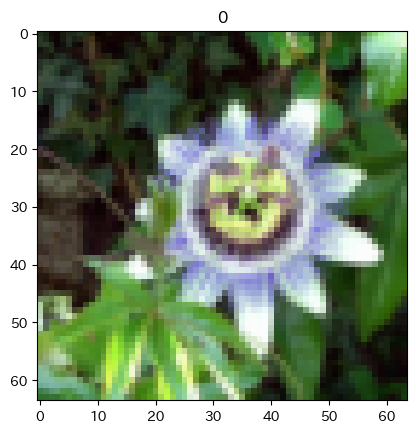

In [6]:
print(trainset)
# データ確認
display(trainset[0][0])
# サイズ確認
print(np.array(trainset[0][0]).shape)
# データの可視化
plt.imshow(trainset[0][0].permute(1,2,0))
plt.title(trainset[0][1])
plt.show()

## 1.1 拡散スケジューリング

In [7]:
def linear_diffusion_schedule(diffusion_times):
    # 線形拡散スケジューリング
    min_rate = 0.0001 # beta_1
    max_rate = 0.02 # beta_2

    betas = min_rate + diffusion_times * (max_rate - min_rate)
    alphas = 1- betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    signal_rates = torch.sqrt(alpha_bars)
    noise_rates = torch.sqrt(1 - alpha_bars)
    return noise_rates, signal_rates

def cosine_diffusion_schedule(diffusion_times):
    signal_rates = torch.cos(diffusion_times * torch.pi / 2)
    noise_rates = torch.sin(diffusion_times * torch.pi / 2)

    return noise_rates, signal_rates

def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = torch.tensor(0.02, device=diffusion_times.device)
    max_signal_rate = torch.tensor(0.95, device=diffusion_times.device)
    start_angle = torch.acos(max_signal_rate)
    end_angle = torch.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)

    return noise_rates, signal_rates

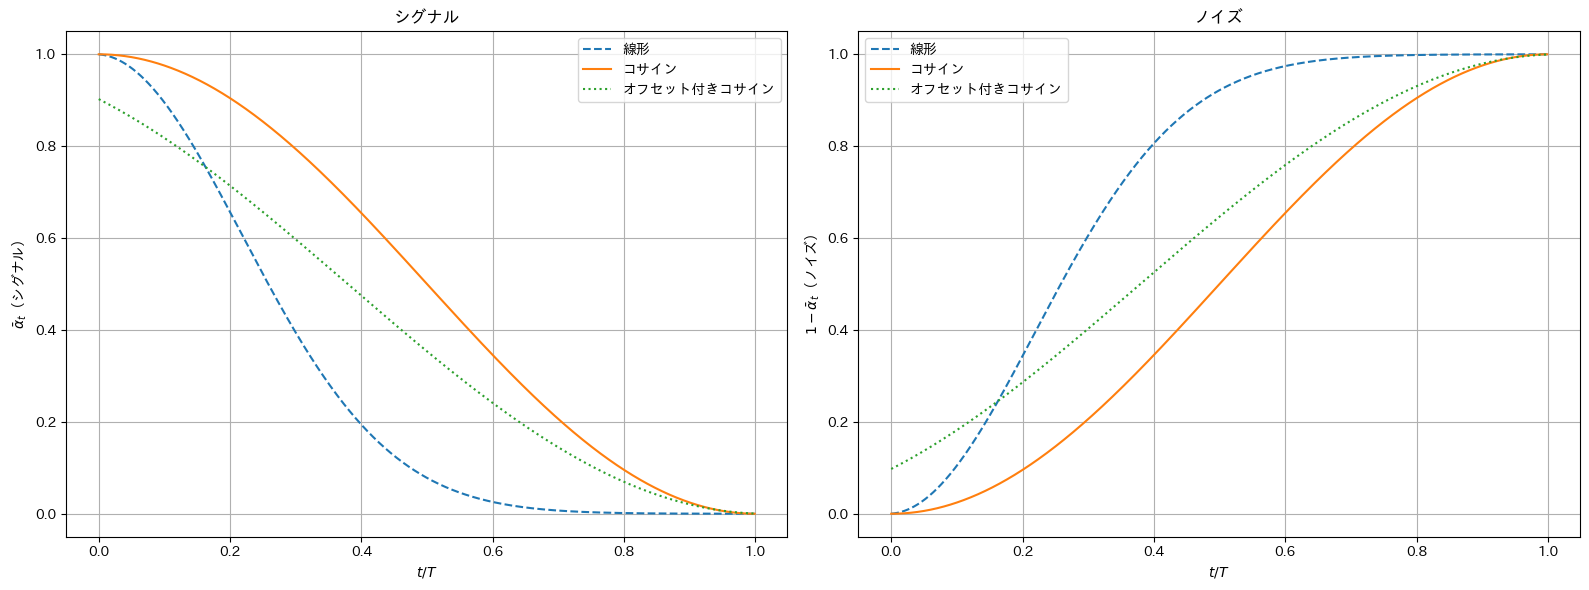

In [8]:
T = 1000
diffusion_times = torch.stack([torch.tensor(x/T) for x in range(T)])
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(diffusion_times)
cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(diffusion_times)
offcosine_noise_rates, offcosine_signal_rates = offset_cosine_diffusion_schedule(diffusion_times)

# 横並びのプロット
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# 信号率のプロット
axs[0].plot(diffusion_times, linear_signal_rates**2, label="線形", linestyle="--")
axs[0].plot(diffusion_times, cosine_signal_rates**2, label="コサイン")
axs[0].plot(diffusion_times, offcosine_signal_rates**2, label="オフセット付きコサイン", linestyle=":")
axs[0].set_title("シグナル")
axs[0].set_xlabel(r"$t/T$")
axs[0].set_ylabel(r"$\bar{\alpha}_{t}$（シグナル）")
axs[0].legend()
axs[0].grid()

# ノイズ率のプロット
axs[1].plot(diffusion_times, linear_noise_rates**2, label="線形", linestyle="--")
axs[1].plot(diffusion_times, cosine_noise_rates**2, label="コサイン")
axs[1].plot(diffusion_times, offcosine_noise_rates**2, label="オフセット付きコサイン", linestyle=":")
axs[1].set_title("ノイズ")
axs[1].set_xlabel(r"$t/T$")
axs[1].set_ylabel(r"$1-\bar{\alpha}_{t}$（ノイズ）")
axs[1].legend()
axs[1].grid()

# プロットを表示
plt.tight_layout()
plt.show()

## 2. モデルの構築

In [9]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        half_dim = embedding_dim // 2
        frequencies = torch.exp(
            torch.linspace(start=torch.log(torch.tensor(1.0)),
                           end=torch.log(torch.tensor(1000.0)),
                           steps=half_dim,
                           )
        )
        self.register_buffer(
            'angular_speeds',
            2.0 * torch.pi * frequencies
        )

    def forward(self, x):
        x = x.squeeze(1).squeeze(1)
        sin = torch.sin(x * self.angular_speeds)
        cos = torch.cos(x * self.angular_speeds)
        emb = torch.cat([sin, cos], dim=1)
        emb = emb.unsqueeze(dim=-1).unsqueeze(dim=-1) # 1ピクセルだけ持つ画像の形式にする
        return emb

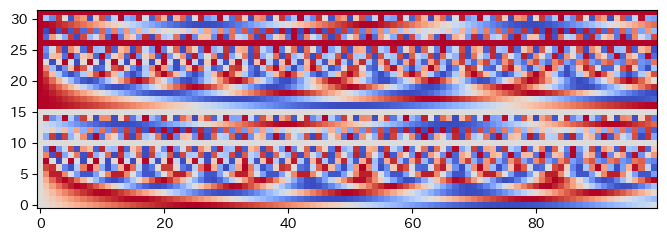

In [10]:

# ノイズ分散の正弦波埋め込みのパターン
emb = SinusoidalEmbedding(NOISE_EMBEDDING_SIZE)
embedding_array = []
for x in torch.arange(0, 1, 0.01):
    embeddings = emb(x.unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0)).squeeze(dim=-1).squeeze(dim=-1)
    embedding_array.append(embeddings)
embedding_array = torch.cat(embedding_array, dim=0).t()

plt.figure(figsize=(8, 6))
plt.imshow(
    embedding_array, cmap="coolwarm", interpolation="nearest",
    origin="lower" # 行列の最初の行がプロットの下側に表示される．
)
plt.show()

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, width):
        super().__init__()
        self.width = width
        # Adjust residual connection if needed
        if in_channels == width:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, width, kernel_size=1)

        # Batch normalization(学習パラメータなし．単純な正規化)
        self.bn = nn.BatchNorm2d(in_channels, affine=False)
        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(width, width, kernel_size=(3, 3), stride=1, padding=1)
        self.silu = nn.SiLU()

    def forward(self, x):
        residual = self.residual_layer(x)
        x = self.bn(x)
        x = self.conv1(x)
        x = self.silu(x)
        x = self.conv2(x)
        x = x + residual
        return x


class DownBlock(nn.Module):
    def __init__(self, in_channels, width, block_depth):
        super().__init__()
        self.blocks = nn.ModuleList()
        for i in range(block_depth):
            if i == 0:
                self.blocks.append(ResidualBlock(in_channels, width))
            else:
                self.blocks.append(ResidualBlock(width, width))

        self.pool = nn.AvgPool2d(kernel_size=(2, 2))

    def forward(self, x, skips):
        for block in self.blocks:
            x = block(x)
            skips.append(x)
        x = self.pool(x)
        return x, skips


class UpBlock(nn.Module):
    def __init__(self, in_channels, width, block_depth):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2,
                                    mode='bilinear',
                                    align_corners=False)
        self.blocks = nn.ModuleList()
        for i in range(block_depth):
            if i == 0:
                self.blocks.append(ResidualBlock(in_channels=width + in_channels, width=width))
            else:
                self.blocks.append(ResidualBlock(in_channels=width + width, width=width))

    def forward(self, x, skips):
        x = self.upsample(x)
        for block in self.blocks:
            skip = skips.pop()
            x = torch.cat([x, skip], dim=1)
            x = block(x)
        return x, skips

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial_conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(1, 1), stride=1, padding=0)

        self.embedding = SinusoidalEmbedding(embedding_dim=NOISE_EMBEDDING_SIZE)
        self.upsampling = nn.Upsample(scale_factor=IMAGE_SIZE, mode='nearest')
        self.down1 = DownBlock(in_channels=32 + NOISE_EMBEDDING_SIZE, width=32, block_depth=2)
        self.down2 = DownBlock(in_channels=32, width=64, block_depth=2)
        self.down3 = DownBlock(in_channels=64, width=96, block_depth=2)

        self.res1 = ResidualBlock(in_channels=96, width=128)
        self.res2 = ResidualBlock(in_channels=128, width=128)

        self.up1 = UpBlock(in_channels=128, width=96, block_depth=2)
        self.up2 = UpBlock(in_channels=96, width=64, block_depth=2)
        self.up3 = UpBlock(in_channels=64, width=32, block_depth=2)

        self.final_conv = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=(1,1), stride=1, padding=0)
        # 学習安定のため，最初はノイズがないことを仮定（ノイズゼロを設定）
        nn.init.zeros_(self.final_conv.weight)
        nn.init.zeros_(self.final_conv.bias)

    def forward(self, noisy_images, noise_variances):
        # ノイズ画像: (BATCH_SIZE, 3, H, W)
        # ノイズ分散：(BATCH_SIZE, 1)
        x  = self.initial_conv(noisy_images)
        noise_embedding = self.embedding(noise_variances)
        noise_embedding = self.upsampling(noise_embedding)
        x = torch.cat([x, noise_embedding], dim=1)

        skips = [] # ダウンブロックでスキップ接続に使う入力を順次格納
        x, skips = self.down1(x, skips)
        x, skips = self.down2(x, skips)
        x, skips = self.down3(x, skips)

        x = self.res1(x)
        x = self.res2(x)

        x, skips = self.up1(x, skips)
        x, skips = self.up2(x, skips)
        x, skips = self.up3(x, skips)

        x = self.final_conv(x)

        return x

In [13]:
class DiffusionModel(nn.Module):
    def __init__(self, denoise_model, diffusion_schedule):
        super().__init__()
        self.network = denoise_model
        self.ema_network = copy.deepcopy(self.network)
        for param in self.ema_network.parameters():
            param.requires_grad = False

        self.diffusion_schedule = diffusion_schedule
        self.normalizer = nn.BatchNorm2d(num_features=3, affine=False)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network(noisy_images, noise_rates ** 2)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def forward(self, images):

        images = self.normalizer(images)
        noises = torch.randn_like(images)
        BATCH_SIZE, _, _, _ = images.size()
        diffusions_times = torch.rand(size=(BATCH_SIZE, 1, 1, 1), device=images.device)

        noise_rates, signal_rates = self.diffusion_schedule(diffusions_times)

        noisy_images = signal_rates * images + noise_rates * noises

        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=True
        )

        return noises, pred_noises

    def reverse_diffusion(self, initial_noise, diffusion_steps, device):
        num_images = initial_noise.size()[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        pred_images = None
        for step in range(diffusion_steps):
            diffusion_times = torch.ones(size=(num_images, 1, 1, 1), device=device) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                current_images, noise_rates, signal_rates, training=False
            )
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
            current_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
        return pred_images.cpu().detach()

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        device = next(self.network.parameters()).device
        if initial_noise is None:
            initial_noise = torch.randn(size=(num_images, 3, IMAGE_SIZE, IMAGE_SIZE), device=device)
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps, device
        )
        generated_images = self.denormalize(generated_images)

        return generated_images

    def denormalize(self, images):
        running_mean = self.normalizer.running_mean
        running_var = self.normalizer.running_var
        eps = self.normalizer.eps
        images = running_mean[None, :, None, None].cpu().detach() + images * torch.sqrt(running_var[None, :, None, None].cpu().detach() + eps)

        return torch.clamp(images, min=0.0, max=1.0)

In [14]:
# Unet(denoise model)
denoise_model = UNet()
torchinfo.summary(denoise_model.eval(), input_size=((1, 3, IMAGE_SIZE, IMAGE_SIZE), (1, 1, 1, 1)))

# Diffusion Model
model = DiffusionModel(denoise_model, offset_cosine_diffusion_schedule)#offset_cosine_diffusion_schedule
model = model.to(device)

## 3. モデルの訓練

In [15]:
optimizer = torch.optim.AdamW(model.network.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# 損失関数の設定 (Mean Absolute Error)
criterion = nn.L1Loss()

In [16]:
# # Train
# metrics_per_epoch = {
#     "loss": [],
# }

# for epoch in range(EPOCHS):
#     epoch_metrics = {metric: 0 for metric in metrics_per_epoch}
#     model.train()
#     for i, data in enumerate(trainloader, 0):
#         images, _ = data
#         images = images.to(device)

#         optimizer.zero_grad()
#         noises, pred_noises = model(images)
#         loss = criterion(pred_noises, noises)
#         loss.backward()
#         optimizer.step()
#         # EMAの更新(学習過程において短期的な変動やスパイクの影響を受けにくい)
#         with torch.no_grad():
#             for param, ema_param in zip(model.network.parameters(), model.ema_network.parameters()):
#                 ema_param.mul_(EMA)
#                 ema_param.add_(param * (1.0 - EMA))
#         # バイアスやバッチノーマライゼーションのパラメータはそのまま引き継ぐ（必須）
#             for buffer, ema_buffer in zip(model.network.buffers(), model.ema_network.buffers()):
#                 ema_buffer.copy_(buffer)

#         epoch_metrics['loss'] += loss.abs().item()
#     # epoch終了時点でのlossの平均値
#     print("Epoch {}:".format(epoch + 1), epoch_metrics)
#     epoch_metrics['loss'] /= len(trainloader)
#     metrics_per_epoch['loss'].append(epoch_metrics['loss'])

#     # 保存先のファイル名を指定
#     save_path = f"./generated_images_{epoch}.png"
#     model.eval()
#     num_images = 5
#     generated_images = model.generate(num_images=num_images, diffusion_steps=20).numpy()

#     # 1つの画像としてプロット
#     plt.figure(figsize=(15, 3))  # サイズ調整 (横長)
#     for i in range(num_images):
#         plt.subplot(1, num_images, i + 1)  # 横に並べる
#         plt.axis("off")
#         plt.title(f"Generated {i + 1}")
#         plt.imshow(generated_images[i].transpose(1, 2, 0))  # チャネルの順序を変更 (H, W, C)
#     plt.tight_layout()
#     plt.savefig(save_path, bbox_inches="tight")
#     plt.close()
#     print(f"Combined image saved to '{save_path}'")

In [17]:
# # modelを保存
# save_path = f"./models/ddm_epoch_{EPOCHS}.pth"

# save_model(model, save_path)

# # metricsを保存
# metrics_save_path = f"./metrics/ddm_metrics.json"
# save_metrics(metrics_per_epoch=metrics_per_epoch, filename=metrics_save_path)

In [18]:
import urllib.request

# モデルのURL
model_url = "https://github.com/sol-sun/Generative_Deep_Learning_2nd_Pytorch/raw/main/08_diffusion/models/ddm_epoch_50.pth"
local_model_path = "ddm_epoch_50.pth"

# モデルをダウンロード
urllib.request.urlretrieve(model_url, local_model_path)

# Move the model to the device and load it
model = load_model(model, local_model_path, device)

Model loaded from ddm_epoch_50.pth


## 4. 画像の生成

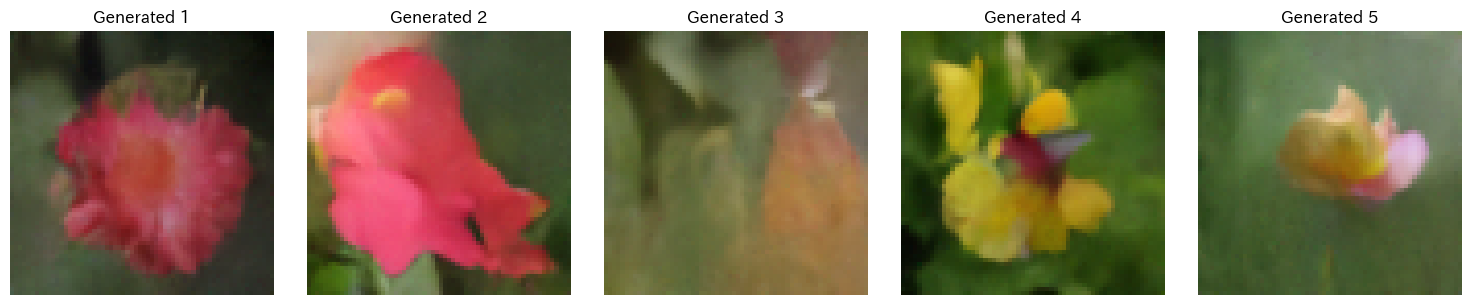

In [19]:
model.eval()
num_images = 5
generated_images = model.generate(num_images=num_images, diffusion_steps=20).numpy()

# 1つの画像としてプロット
plt.figure(figsize=(15, 3))  # サイズ調整 (横長)
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)  # 横に並べる
    plt.axis("off")
    plt.title(f"Generated {i + 1}")
    plt.imshow(generated_images[i].transpose(1, 2, 0))  # チャネルの順序を変更 (H, W, C)
# 保存
plt.tight_layout()
plt.show()

In [20]:
def spherical_interpolation_simple(a, b, t):
    return torch.sin(t * torch.pi / 2) * a + torch.cos(t * torch.pi / 2) * b

def slerp(a, b, t):
    """
    画像a,b間の球面線形補間(SLERP)を行う．
    """
    a_norm = a / torch.norm(a, dim=[-1,-2], keepdim=True)
    b_norm = b / torch.norm(b, dim=[-1,-2], keepdim=True)
    dot = torch.sum(a_norm * b_norm, dim=[-1,-2], keepdim=True).clamp(-1.0, 1.0)

    theta = torch.acos(dot)  # Angle between a and b
    sin_theta = torch.sin(theta)

    factor_a = torch.sin((1 - t) * theta) / sin_theta
    factor_b = torch.sin(t * theta) / sin_theta
    return factor_a * a + factor_b * b

### 4.1 spherical_interpolation_simpleを用いた画像生成（書籍の内容通り）

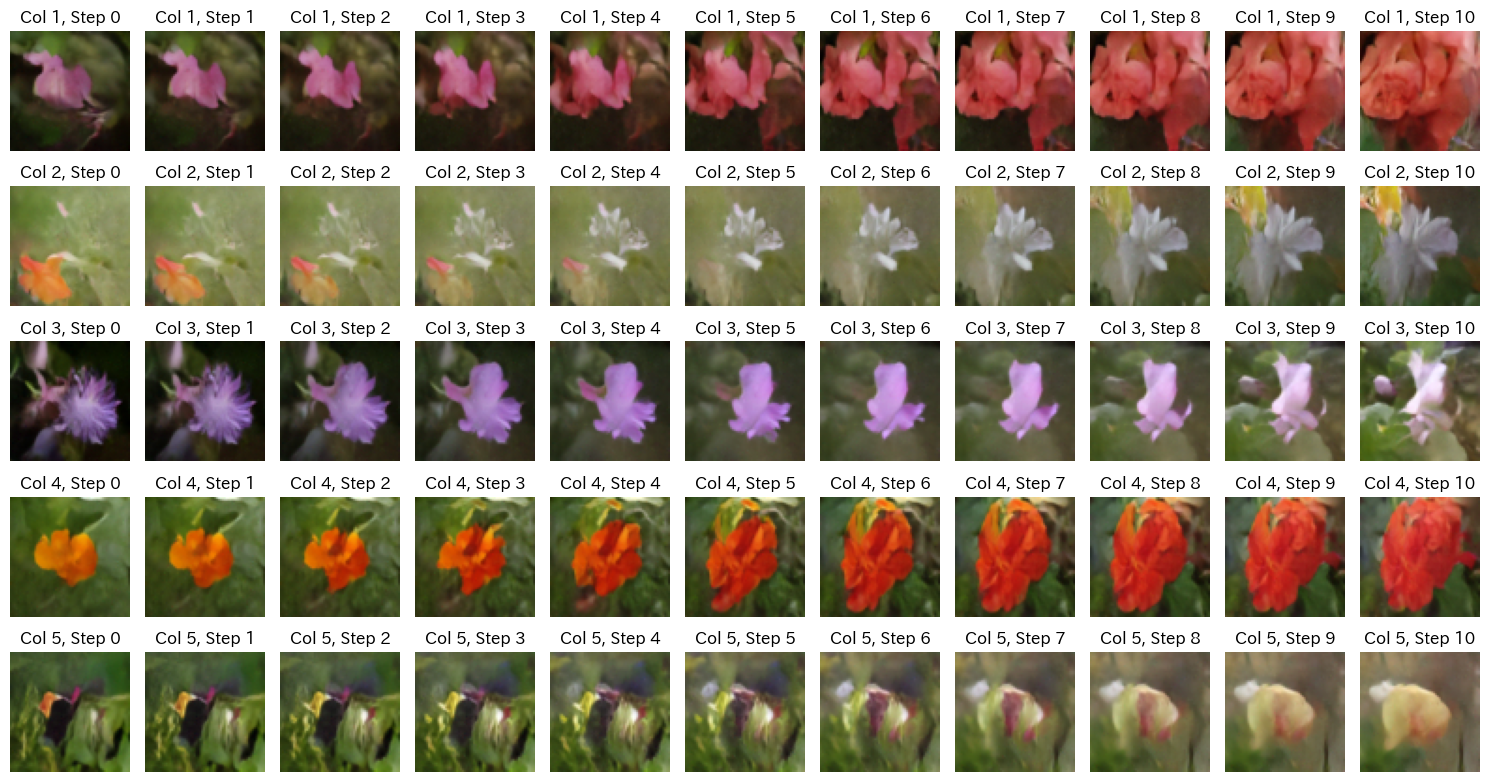

In [21]:
# spherical_interpolation_simpleを用いた画像生成
n = 5  # 列数
t_values = torch.arange(0, 1.1, 0.1)  # tの補間ステップ

all_generated_images = []  # 生成された画像を保存するリスト

for col in range(n):
    a = torch.randn(size=(1, 3, IMAGE_SIZE, IMAGE_SIZE))
    b = torch.randn(size=(1, 3, IMAGE_SIZE, IMAGE_SIZE))
    initial_noise = torch.cat(
        [spherical_interpolation_simple(a, b, t) for t in t_values]
    )
    generated_images = model.generate(
        num_images=1, diffusion_steps=20, initial_noise=initial_noise
    ).numpy()
    all_generated_images.append(generated_images)

# 描画
plt.figure(figsize=(15, 1.6 * n))
for col in range(n):
    for row in range(len(t_values)):
        plt.subplot(n, len(t_values), col * len(t_values) + row + 1)
        plt.axis("off")
        plt.title(f"Col {col + 1}, Step {row}")
        plt.imshow(all_generated_images[col][row].transpose(1, 2, 0))  # チャネルの順序を変更 (H, W, C)に変換

# 保存
plt.tight_layout()
plt.show()

### 4.2 slerpを用いた画像生成

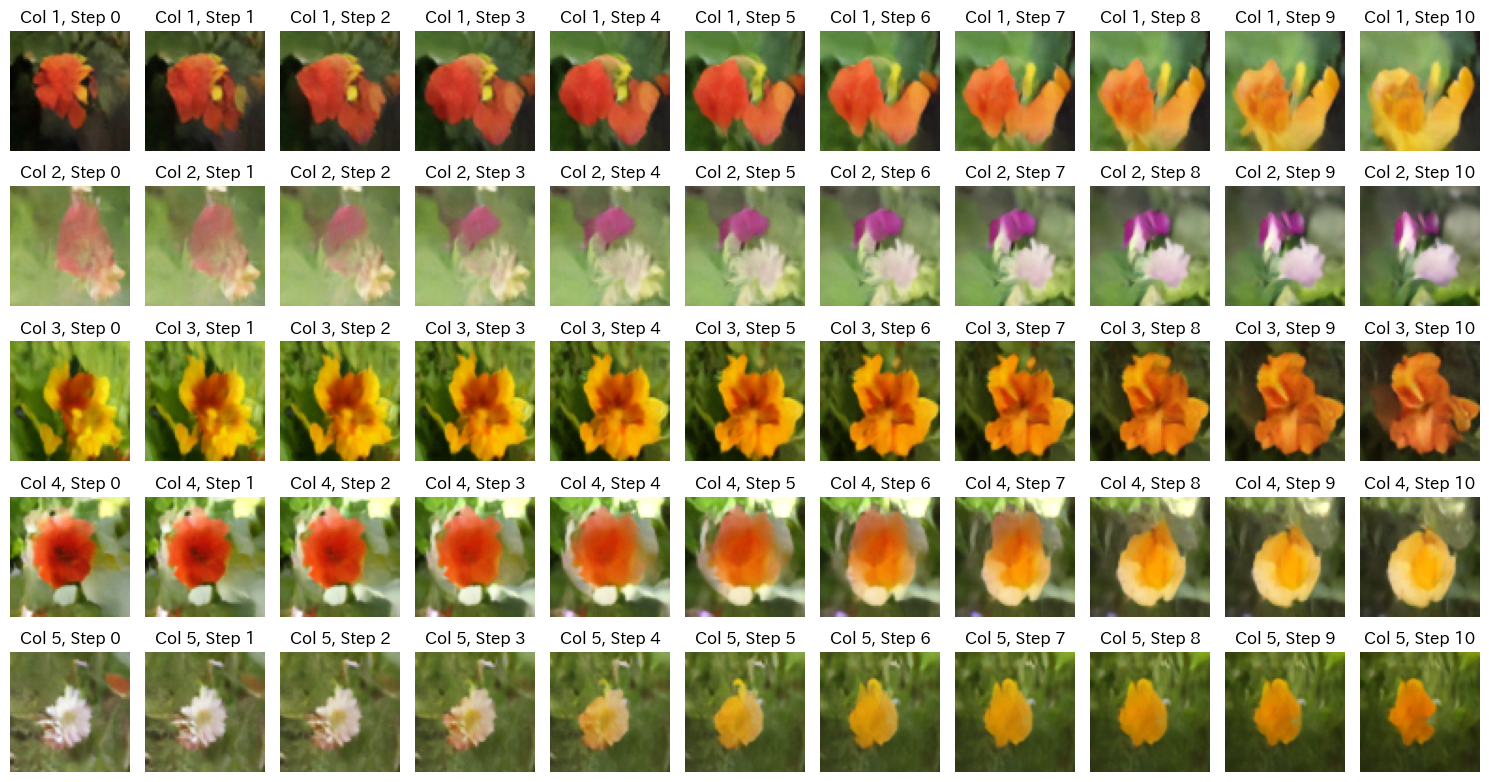

In [22]:
n = 5  # 列数
t_values = torch.arange(0, 1.1, 0.1)  # tの補間ステップ

all_generated_images = []  # 生成された画像を保存するリスト

for col in range(n):
    a = torch.randn(size=(1, 3, IMAGE_SIZE, IMAGE_SIZE))
    b = torch.randn(size=(1, 3, IMAGE_SIZE, IMAGE_SIZE))
    initial_noise = torch.cat(
        [slerp(a, b, t) for t in t_values]
    )
    generated_images = model.generate(
        num_images=1, diffusion_steps=20, initial_noise=initial_noise
    ).numpy()
    all_generated_images.append(generated_images)

# 描画
plt.figure(figsize=(15, 1.6 * n))
for col in range(n):
    for row in range(len(t_values)):
        plt.subplot(n, len(t_values), col * len(t_values) + row + 1)
        plt.axis("off")
        plt.title(f"Col {col + 1}, Step {row}")
        plt.imshow(all_generated_images[col][row].transpose(1, 2, 0))  # チャネルの順序を変更 (H, W, C)に変換

# 保存
plt.tight_layout()
plt.show()